<a href="https://colab.research.google.com/github/MimaDalix/Deep-Learning-tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then  we can adapt those patterns to our own data

In [13]:
# Are we using a GPU?
!nvidia-smi

Sat Oct 15 12:31:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    29W /  70W |    446MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dowloading and becoming one with the data

In [14]:
# Get data (10% od 10 foss classes from Food101)
import zipfile

# Download the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

# Unzip the downloaded file 
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-15 12:31:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   269MB/s    in 0.6s    

2022-10-15 12:31:07 (269 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [15]:
# How many images in each folder
import os 

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/train'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'. 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'. 
There are 0 directories and 75 images in '10_food_classes

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches 

In [16]:
# Setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callback (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be peformed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [17]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir} ")
  return tensorboard_callback 

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.
The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub 

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub .

We can access pretrained models on: https://tfhub.dev/ 

Browing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/google/efficientnet/b0/feature-vector/1 

In [18]:
# Let's compare the following two models 
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [19]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras import layers

In [20]:
# Let's make a create_model() function to create a model from a URL 
def create_model(model_url, num_classes):
  """ 
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlwo Hub feature extraction URL.
  num_classes (int): Number pd output neurons in the output layer,
   should be equal to number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor 
  layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))   # Freeze the already trained patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub feature Extraction model 

In [21]:
# Create ResNet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [24]:
# Compile the model 
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [26]:
#Let's Fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221015-124028 
Epoch 1/5
24/24 [==============================] - 16s 674ms/step - loss: 0.2990 - accuracy: 0.9413 - val_loss: 0.6464 - val_accuracy: 0.7876
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.2476 - accuracy: 0.9613 - val_loss: 0.6367 - val_accuracy: 0.7876
Epoch 3/5
24/24 [==============================] - 15s 650ms/step - loss: 0.2128 - accuracy: 0.9733 - val_loss: 0.6443 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - 15s 658ms/step - loss: 0.1841 - accuracy: 0.9773 - val_loss: 0.6247 - val_accuracy: 0.7928
Epoch 5/5
24/24 [==============================] - 16s 690ms/step - loss: 0.1571 - accuracy: 0.9867 - val_loss: 0.6270 - val_accuracy: 0.7904


In [22]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Wow! 

That is incredible!! Our transfer learning extractor model out performed ALL of the previous models we built by hands ... (substantially) and in a quicker training time and with only 10% of the training examples.

In [27]:
# Let's create a function to plot our loss curves 
# Tidbit you could put a function like this into a script called "helper.py" and import it when needed
import matplotlib.pyplot as plt 

def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
   Plots of training/validation loss and accuracy metrics.

  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss 
  
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot the accuracy curve
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='validation_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

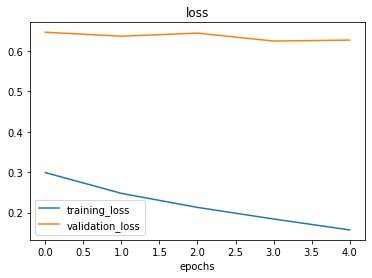

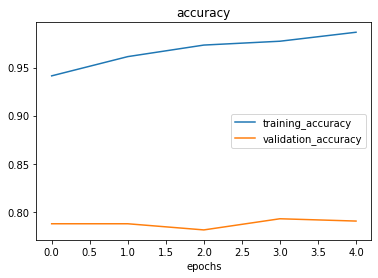

In [28]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [29]:
# Create the Efficientnet model - details on efficientnet : https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html 
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

In [30]:
# Compile the model 
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [32]:
# Fit the Efficientnet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data= test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221015-131420 
Epoch 1/5
24/24 [==============================] - 20s 722ms/step - loss: 1.8379 - accuracy: 0.4360 - val_loss: 1.2842 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 15s 629ms/step - loss: 1.0450 - accuracy: 0.7867 - val_loss: 0.8583 - val_accuracy: 0.8260
Epoch 3/5
24/24 [==============================] - 15s 624ms/step - loss: 0.7460 - accuracy: 0.8480 - val_loss: 0.6902 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 15s 628ms/step - loss: 0.5956 - accuracy: 0.8733 - val_loss: 0.6042 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 632ms/step - loss: 0.5033 - accuracy: 0.8987 - val_loss: 0.5522 - val_accuracy: 0.8632


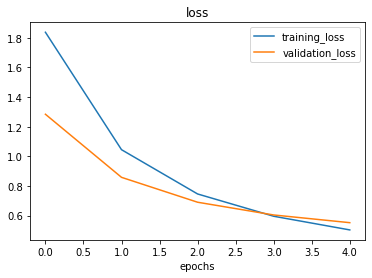

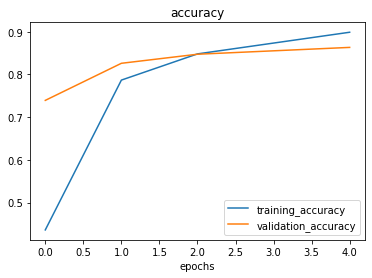

In [33]:
plot_loss_curves(efficientnet_history)

In [34]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [35]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [37]:
# How many layers does our efficientb0 feature ectractor have ? 
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning 

* "As is" transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 -> 10 classes of food)
* "Fine-Tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models result using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't wish others to see) do not upload them on TensorBoard.dev . 

In [40]:
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Jdeh9p1CAwYBwrYmcoswGmaXOMDikj&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/AHW8PeBMSOmovnDWe6BBBQ/#scalars 

In [41]:
# Check out what TensorBoard experiments you have 
!tensorboard dev list

https://tensorboard.dev/experiment/AHW8PeBMSOmovnDWe6BBBQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   AHW8PeBMSOmovnDWe6BBBQ
	Created              2022-10-15 13:40:28 (4 minutes ago)
	Updated              2022-10-15 13:40:32 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3266672
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --eperiment_id AHW8PeBMSOmovnDWe6BBBQ

In [42]:
# Confirm the deletion by re-checking what experiments you have left 
!tensorboard dev list

https://tensorboard.dev/experiment/AHW8PeBMSOmovnDWe6BBBQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   AHW8PeBMSOmovnDWe6BBBQ
	Created              2022-10-15 13:40:28 (6 minutes ago)
	Updated              2022-10-15 13:40:32 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3266672
Total: 1 experiment(s)
